# Distinguishability of Best and Worst Matches

**March 27, 2025**

**Joshua D. Ingram**

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Add parent directory to Python path
# Parent should be: "../starsml/"
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from src.utils import ks_test_filter_ranges, create_bins_min_count, setup_paths

## Data

In [2]:
paths = setup_paths()
first_match = pd.read_csv(os.path.join(paths["data"], "most_probable_new.csv"))
second_match = pd.read_csv(os.path.join(paths["data"], "second_new.csv"))
last_match = pd.read_csv(os.path.join(paths["data"], "last_new.csv"))

In [3]:
# Removing incomplete rows (missing separation or off-axis angle)
# Removed ~ 30,000 rows
first_match = first_match[first_match["dist_arcsec"].notna() & first_match["min_theta_mean"].notna()]
second_match = second_match[second_match["dist_arcsec"].notna() & second_match["min_theta_mean"].notna()]
last_match = last_match[last_match["dist_arcsec"].notna() & last_match["min_theta_mean"].notna()]

## Fixed-Bin Analysis

In [4]:
# Create the bins to be used for analysis (based on dist_arcsec = separation)
bin_edges = create_bins_min_count(first_match, "dist_arcsec", min_count = 1000)

### G Mean Magnitude

In [6]:
VARIABLE = "phot_g_mean_mag"
FILTER_COLUMN1 = "dist_arcsec"
FILTER_COLUMN2 = "min_theta_mean"
FILTER_COUNT = "first"
UNIQUE_ID = "chandra_source_id"

In [7]:
# Separation filters
filter1_separation = bin_edges[:-1]
filter2_separation = bin_edges[1:]

# Off-axis filters
filter1_offaxis = [0, 3, 5]
filter2_offaxis = [3, 5, float("inf")]

In [11]:
# Two-Sided, Two-Sample KS Test results
# NOTE: dropping rows with missing values
results = []

for i in range(len(filter1_separation)):
    for j in range(len(filter1_offaxis)):
        ks_test_results = ks_test_filter_ranges(first_match, last_match,
                                                VARIABLE, FILTER_COLUMN1, FILTER_COLUMN2,
                                                filter1_separation[i], filter2_separation[i],
                                                filter1_offaxis[j], filter2_offaxis[j],
                                                unique_id=UNIQUE_ID, filter_count=FILTER_COUNT)
        results.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                        'min_sep': filter1_separation[i], 'max_sep': filter2_separation[i], 'med_sep': (filter1_separation[i] + filter2_separation[i])/2,
                        'min_offaxis': filter1_offaxis[j], 'max_offaxis': filter2_offaxis[j], 
                        'filter_by': FILTER_COUNT, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(results)

In [12]:
ks_test_results_df

,statistic,pvalue,min_sep,max_sep,med_sep,min_offaxis,max_offaxis,filter_by,n_first,n_second
0,0.332019,1.425544e-35,0.000000,0.030257,0.015129,0,3.0,first,719,719
1,0.418269,1.102906e-16,0.000000,0.030257,0.015129,3,5.0,first,209,209
2,0.611111,7.249085e-13,0.000000,0.030257,0.015129,5,inf,first,72,72
3,0.325265,2.728487e-32,0.030257,0.048175,0.039216,0,3.0,first,685,685
4,0.344265,2.046196e-11,0.030257,0.048175,0.039216,3,5.0,first,209,209
...,...,...,...,...,...,...,...,...,...,...
271,0.100206,1.438581e-01,8.289991,9.297387,8.793689,3,5.0,first,254,254
272,0.048127,6.567400e-01,8.289991,9.297387,8.793689,5,inf,first,447,447
273,0.144737,4.057396e-01,9.297387,9.998549,9.647968,0,3.0,first,77,77
274,0.117647,6.015804e-01,9.297387,9.998549,9.647968,3,5.0,first,85,85


#### Figure

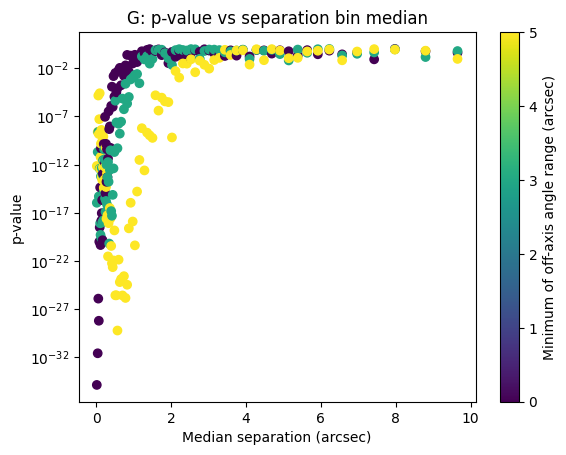

In [13]:
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()